<a href="https://colab.research.google.com/github/JacksonLeb/tensorflow_learning/blob/main/08_rnn_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#introduction to NLP fundamentals in Tf

##Getting info from natural language (sequences or speech)
##NLP can also be called seq2seq problems

###Checking for GPU


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0e0f1dd3-adec-e3fe-c3a5-6808e9744f7d)


In [2]:
##Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-29 23:41:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-29 23:41:50 (98.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
##Get a text dataset
###Using the Kaggle Intro to NLP dataset, samples of tweets labeled hazard or not
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-07-29 23:41:55--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.04s   

2022-07-29 23:41:56 (15.8 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
unzip_data("nlp_getting_started.zip")

##Visualizing a text dataset

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
train_df["text"][10]

'Three people died from the heat wave so far'

In [9]:
train_df["text"][100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [10]:
#shuffle trianing df
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
#test df
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
#examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
#total num of samples
len(train_df), len(test_df)

(7613, 3263)

In [14]:
#visualizing random samples
import random
random_index = random.randint(0, len(train_df)-5) #create random index
for row in train_df_shuffled[["text", "target"]][random_index:random_index +5 ].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}")

Target: 1 (real disaster
Text:
All Hail Shadow (Hybrid Mix Feat. Mike Szuter): http://t.co/9e2f7bIvlE @youtube ##youtube
Target: 0 (not real disaster)
Text:
Not one character in the final destination series has ever survived ??
Target: 0 (not real disaster)
Text:
We're #hiring! Read about our latest #job opening here: Emergency Department Psychiatric RN (.90 FTE Day) - http://t.co/zOEpZsOkY1
Target: 1 (real disaster
Text:
Intact+MH370+Part+Lifts+Odds+Plane+Glided+Not+Crashed+Into+Sea http://t.co/MjTN3qbgOS via @YahooFinance#Hope for answers.
Target: 1 (real disaster
Text:
FedEx no longer will ship potential bioterror pathogens - FedEx Corp. (NYSE: FDX) will no longer deliver packages ... http://t.co/2kdq56xTWs


In [15]:
#splittting data into training and validation
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=30)

In [16]:
#checking lengths of each data set
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [17]:
#check the first 10 sentences
train_sentences[:10]

array(["All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       "@DavidJordan88 @Stephanenny Except we don't know who started the riot or if it even makes sense to credit any particular individuals...",
       'Shadow boxing the apocalypse',
       "Maybe that's what happens when a tornado meets a volcano",
       '#Politics Democracy\x89Ûªs hatred for hate: \x89Û_ Dawabsha threaten to erode Israeli democracy. Homegrown terrorism ha...  http://t.co/q8n5Tn8WME',
       "@TomDean86 he's alright but Hazard/Willian ain't gonna be shifted easily.",
       '0-day bug in fully patched OS X comes under active exploit to hijack Macs http://t.co/sbGiRvQvzb',
       'Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/su4ZVWADj7',
       'If it\x89Ûªs a war you came to see you will never see a waved white flag in front me.\nI can\x89Ûªt end up dead I wont be misled.',
     

In [18]:
val_sentences[:10]

array(['Blaze is my bro http://t.co/UdKeSJ01mL',
       'I was taught at school in the 1970s that piracy slavery and suicide-bombing were purely historical. No one then expected them to re-occur',
       'http://t.co/FueRk0gWui Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/Mv7GgGlmVc',
       "I'm a friggin wreck destiel sucks (read the vine description)\nhttps://t.co/MKX6Ux4OZt",
       'Dr. Bengston on #wildfire management: \x89ÛÏnumbers and size of fires areas affected and costs of fighting them all show upward trend.\x89Û\x9d #smem',
       '@ameenshaikh3 sir i just only wanted to make a point about @sureshpprabhu you made and said he is lying about bridge collapse.',
       'Wow! I just won this for free The Hobbit: Desolation of Smaug UV digital download code *GIN 9 http://t.co/MjFdCrjs8j #listia',
       'Photoset: hakogaku: ?åÊI am a kurd. i was born on a battlefield. raised on a battlefield. gunfire sirens... http://t.co/obp595W7tm',
       'Wash

## Converting text into numbers

#Tokenization and Embedding
##Tokenization: Each word/character is set to a number/one-hot encoding
##Embedding: Each word/character is set to a vector, with user-defined size, allowing for information on the relationship between tokens/words/characters. Additionally, can limit size and can be learned (treated as a weight matrix)


In [19]:
#Text Vectorization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

#Use default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, #how many words in vocabulary (automaticaly add <OOV>)
                                    standardize="lower_and_strip_punctuation", #remove fluff,
                                    split="whitespace",
                                    ngrams=None, #create groups of n words
                                    output_mode="int", #how to map tokens to numbers
                                    output_sequence_length=None, #how long each batch of a setence should be
                                    pad_to_max_tokens=False)


In [20]:
#find average number of tokens (words) in the trianing tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [21]:
#set up text vectorization variables
max_vocab_length = 10000 # max num of words to have in vocabulary
max_length = 15 #max length of a tweet that our models sees

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #how many words in vocabulary (automaticaly add <OOV>)
                                    standardize="lower_and_strip_punctuation", #remove fluff,
                                    split="whitespace",
                                    ngrams=None, #create groups of n words
                                    output_mode="int", #how to map tokens to numbers
                                    output_sequence_length=max_length, #how long each batch of a setence should be
                                    pad_to_max_tokens=True)

In [22]:
#adapting text_vectorizer to training data
text_vectorizer.adapt(train_sentences) #adapt to training data, very important

In [23]:
train_sentences[:10]

array(["All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       "@DavidJordan88 @Stephanenny Except we don't know who started the riot or if it even makes sense to credit any particular individuals...",
       'Shadow boxing the apocalypse',
       "Maybe that's what happens when a tornado meets a volcano",
       '#Politics Democracy\x89Ûªs hatred for hate: \x89Û_ Dawabsha threaten to erode Israeli democracy. Homegrown terrorism ha...  http://t.co/q8n5Tn8WME',
       "@TomDean86 he's alright but Hazard/Willian ain't gonna be shifted easily.",
       '0-day bug in fully patched OS X comes under active exploit to hijack Macs http://t.co/sbGiRvQvzb',
       'Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/su4ZVWADj7',
       'If it\x89Ûªs a war you came to see you will never see a waved white flag in front me.\nI can\x89Ûªt end up dead I wont be misled.',
     

In [24]:
#Create sample setnces and tokenize it
sample_sentence = "A tornado destroyed my house"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  3, 595, 346,  13, 311,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
#Choose a random sentence from the triaing dataset and vectorize it
random_sentence = random.choice(train_sentences)
print(f"original sentence: {random_sentence}\n vectorized sentence: {text_vectorizer([random_sentence])}")

original sentence: Fire destroys two buildings on 2nd Street in #Manchester http://t.co/Tqh5amoknd
 vectorized sentence: [[  42 1682  112   95   11 1321  768    4 1509    1    0    0    0    0
     0]]


In [26]:
#number of unique words found in train_sentences
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Num of words: {len(words_in_vocab)}")
top_5_words, bottom_5_words

Num of words: 10000


(['', '[UNK]', 'the', 'a', 'in'],
 ['panda', 'panama', 'pampalmater', 'palmoil', 'palmer'])

### Creating an embedding using an embedding layer


In [27]:
#using tensorflow.keras.layeres.Embedding
##Parameters: input_dim, output_dim, input_length
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)
embedding

In [28]:
#get a random sentence
random_sentence = random.choice(train_sentences)
print(f"random sentence: {random_sentence}")
print(f"embedded:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

random sentence: Schools in Western Uganda still Burning down Buildings during Strikes....Strikes in Western Uganda always Lit literally..
embedded:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0452236 ,  0.03141561,  0.02913788, ..., -0.00118339,
         -0.04397987,  0.00972264],
        [ 0.00183608, -0.04843877,  0.02644466, ...,  0.01672338,
          0.03407112, -0.03431299],
        [ 0.03962276,  0.0281941 , -0.02019731, ...,  0.01635191,
          0.0130245 , -0.01942028],
        ...,
        [ 0.03281746, -0.03156985,  0.04017032, ...,  0.03974494,
         -0.03434937, -0.02282306],
        [-0.02705061,  0.03860979,  0.03364316, ...,  0.01110797,
         -0.0144449 , -0.02146479],
        [-0.01488053, -0.04358071,  0.02179985, ...,  0.04913285,
          0.02247113, -0.00646057]]], dtype=float32)>

In [29]:
sample_embed[0][0], sample_embed[0][0].shape, 

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.0452236 ,  0.03141561,  0.02913788, -0.04062421, -0.00592729,
        -0.04106276,  0.01070071,  0.03806493,  0.01652802, -0.02945913,
         0.01806333,  0.03679129,  0.04044348,  0.02869301, -0.01625561,
        -0.04898978, -0.00045128, -0.04144446,  0.01823268,  0.00211778,
         0.01064168,  0.03465218, -0.0287895 , -0.03373549, -0.01278378,
        -0.02062348, -0.0395159 , -0.02650925,  0.0499027 , -0.00606375,
         0.02659578, -0.01287929, -0.01828343, -0.04291074, -0.00848851,
         0.0473741 ,  0.04444145, -0.03544552,  0.02954802,  0.01551714,
        -0.0207575 , -0.03121271,  0.04374574, -0.03598351, -0.04127133,
        -0.03295872, -0.02572646, -0.04490102, -0.01448663,  0.03100299,
        -0.00089191, -0.00917115,  0.0024568 ,  0.01845298, -0.04842609,
         0.01360333,  0.04751105,  0.01494617, -0.03144766,  0.04788348,
         0.00843444, -0.01428337,  0.03629142,  0.02328267, -0.01011493,
  

##Modelling a text dataset (running series of experiments)
###1. Naive bayes with Tf-IDF encoder (BASELINE)
###2. Feed-forward neural network 
###3. LSTM
###4. GRU
###5. Bidirectiona;-LSTM
###6. 1D CNN
###7. TFHub pretrianed feature extractor
###8. TFHub pretrained with 10% of trained datam



In [30]:
###Model 0: Getting a baseline - Skleanrs multinomial naive bayes with tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), #convert words to numbers
                    ("clf", MultinomialNB()) #model the text

])

#fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
#Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)

In [32]:
baseline_score

0.8044619422572179

In [33]:
print(f"Baseline Score: {baseline_score*100:.2f}%")

Baseline Score: 80.45%


In [34]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:30]

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1])

In [35]:
### creating an evaluation function for our modeling experiements
#Accuracy, Precision, Recall and f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, preicision, recall and f1-score
  """
  #calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  #precision, recall and f1-score(using weighted average)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [36]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 80.4461942257218,
 'f1': 0.7993754401853582,
 'precision': 0.8113250534023555,
 'recall': 0.8044619422572179}

In [37]:
### Model 1: Feed Forward NN

# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"


In [38]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [40]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220729-234205
Epoch 1/5
215/215 [==============================] - 8s 9ms/step - loss: 0.6111 - accuracy: 0.6911 - val_loss: 0.5128 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4419 - accuracy: 0.8203 - val_loss: 0.4405 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3480 - accuracy: 0.8610 - val_loss: 0.4282 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2849 - accuracy: 0.8911 - val_loss: 0.4433 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2378 - accuracy: 0.9095 - val_loss: 0.4592 - val_accuracy: 0.7966


In [42]:
#check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4592 - accuracy: 0.7966


[0.45924991369247437, 0.7965879440307617]

In [43]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[5.37914075e-02],
       [6.96465015e-01],
       [9.98150766e-01],
       [1.31870344e-01],
       [9.80363786e-01],
       [6.27877936e-02],
       [7.56874401e-03],
       [2.02316806e-01],
       [9.96931434e-01],
       [9.83283162e-01],
       [2.76331287e-02],
       [1.86020911e-01],
       [9.99602020e-01],
       [5.73287122e-02],
       [4.94151004e-02],
       [5.44042647e-01],
       [9.98282671e-01],
       [2.54923612e-01],
       [5.64044178e-01],
       [4.28021640e-01],
       [1.17599018e-01],
       [3.55447173e-01],
       [9.07391548e-01],
       [5.72837293e-01],
       [3.69972825e-01],
       [9.98697639e-01],
       [2.66075701e-01],
       [2.93688793e-02],
       [9.72792745e-01],
       [9.99867082e-01],
       [9.99240160e-01],
       [1.98807493e-01],
       [4.53556538e-01],
       [3.25399749e-02],
       [8.30826312e-02],
       [9.65913594e-01],
       [8.03101808e-03],
       [4.13990647e-01],
       [3.88534069e-01],
       [5.04221842e-02],


In [44]:
model_1_pred_probs[0]

array([0.05379141], dtype=float32)

In [45]:
model_1_pred_probs.shape

(762, 1)

In [46]:
model_1_pred_probs[:10]

array([[0.05379141],
       [0.696465  ],
       [0.99815077],
       [0.13187034],
       [0.9803638 ],
       [0.06278779],
       [0.00756874],
       [0.2023168 ],
       [0.99693143],
       [0.98328316]], dtype=float32)

In [47]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1

In [48]:
#Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.65879265091863,
 'f1': 0.7963742745836615,
 'precision': 0.7962301652859638,
 'recall': 0.7965879265091863}

In [49]:
baseline_results = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [50]:
words_in_vocab

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'with',
 'it',
 'that',
 'at',
 'by',
 'this',
 'from',
 'be',
 'are',
 'was',
 'have',
 'like',
 'me',
 'as',
 'up',
 'just',
 'but',
 'so',
 'im',
 'not',
 'amp',
 'your',
 'out',
 'its',
 'all',
 'will',
 'after',
 'no',
 'fire',
 'has',
 'an',
 'when',
 'if',
 'get',
 'now',
 'we',
 'about',
 'new',
 'via',
 'more',
 'or',
 'people',
 'what',
 'news',
 'one',
 'how',
 'he',
 'they',
 'over',
 'dont',
 'been',
 'who',
 'into',
 'video',
 'were',
 'do',
 'can',
 '2',
 'us',
 'disaster',
 'emergency',
 'there',
 'police',
 'than',
 'would',
 'still',
 'his',
 'some',
 'her',
 'body',
 'burning',
 'storm',
 'crash',
 'back',
 'had',
 'suicide',
 'man',
 'why',
 'know',
 'got',
 'them',
 'buildings',
 'world',
 'time',
 'off',
 'see',
 'california',
 'first',
 'day',
 'rt',
 'bomb',
 'youtube',
 'cant',
 'love',
 'nuclear',
 'going',
 'their',
 'dead',
 'two',
 'train',
 'killed',
 'go'

In [51]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [52]:
#get weight matrix of embedding layer
#numerical representations of each token in our training data, learned for 5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [53]:
embed_weights

array([[ 0.00605106,  0.05858438,  0.03330769, ..., -0.01084881,
        -0.0546153 , -0.03695693],
       [-0.03272963, -0.01187464, -0.03309455, ..., -0.02592053,
        -0.00891416, -0.00070886],
       [-0.04949095, -0.00930552,  0.00076833, ...,  0.03429968,
        -0.03405045, -0.03086733],
       ...,
       [ 0.09021532, -0.05739602,  0.02803511, ...,  0.10618759,
         0.04523646,  0.05639001],
       [ 0.02892767, -0.04199115,  0.02619302, ...,  0.00657955,
         0.05643053,  0.03471509],
       [-0.0972536 ,  0.10309324, -0.08894882, ..., -0.02059617,
        -0.08486234, -0.05977146]], dtype=float32)

In [54]:
#projector tool
import io
out_v = io.open('vectors.tsv', 'w', encoding="utf-8")
out_m = io.open('metadata.tsv', 'w', encoding="utf-8")

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue

  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [55]:
#download files from colab and upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Recurrent Neural Network

##useful for sequence data - use representation of previous input to aid the representation of a later input

In [56]:
### Model 2: LSTM
###LSTM = Long Short Term Memory (one of the most popular RNN)
'''
 input(text) -> toeknize -> embed -> layers (RNNs/Dense) -> Output
'''

'\n input(text) -> toeknize -> embed -> layers (RNNs/Dense) -> Output\n'

In [57]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [58]:
#Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [59]:
#compile
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220729-234220
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.2205 - accuracy: 0.9222 - val_loss: 0.5075 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1527 - accuracy: 0.9431 - val_loss: 0.6077 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1266 - accuracy: 0.9526 - val_loss: 0.5736 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1060 - accuracy: 0.9585 - val_loss: 0.8191 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0873 - accuracy: 0.9661 - val_loss: 0.9013 - val_accuracy: 0.7480


In [61]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[4.2142454e-03],
       [9.3022501e-01],
       [9.9973530e-01],
       [2.2971680e-02],
       [9.9961889e-01],
       [1.5341596e-02],
       [3.7634306e-04],
       [8.6112069e-03],
       [9.9980146e-01],
       [9.9948394e-01]], dtype=float32)

In [62]:
#convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1.], dtype=float32)>

In [63]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

In [64]:
model_2_results

{'accuracy': 74.80314960629921,
 'f1': 0.7490377867542259,
 'precision': 0.7517838304192558,
 'recall': 0.7480314960629921}

In [65]:
#Model 3: GRU
#GRU = Gated recurrent unit
##GRU is similar to LSTM, but has less parameters

In [66]:
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")


inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

'''
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")
'''


'\n# Build an RNN using the GRU cell\ninputs = layers.Input(shape=(1,), dtype="string")\nx = text_vectorizer(inputs)\nx = model_3_embedding(x)\n# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True\nx = layers.GRU(64)(x) \n# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell\noutputs = layers.Dense(1, activation="sigmoid")(x)\nmodel_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")\n'

In [67]:
#compile
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [69]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220729-234233
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1520 - accuracy: 0.9369 - val_loss: 0.7763 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0829 - accuracy: 0.9693 - val_loss: 0.8705 - val_accuracy: 0.7441
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0729 - accuracy: 0.9714 - val_loss: 0.9432 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0625 - accuracy: 0.9749 - val_loss: 0.8945 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0579 - accuracy: 0.9750 - val_loss: 1.0450 - val_accuracy: 0.7533


In [70]:
model_3_preds = tf.squeeze(tf.round(model_3.predict(val_sentences)))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1

In [71]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

In [72]:
model_3_results

{'accuracy': 75.32808398950131,
 'f1': 0.75402691938125,
 'precision': 0.7556144297752255,
 'recall': 0.7532808398950132}

In [73]:
#Model 4: Bidirectional RNN
##goes left to right and right to left

In [74]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4")

In [75]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [76]:
#compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
# Fit model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Bidrectional")])

Saving TensorBoard log files to: model_logs/Bidrectional/20220729-234246
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1029 - accuracy: 0.9707 - val_loss: 0.9861 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0513 - accuracy: 0.9781 - val_loss: 1.1695 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0487 - accuracy: 0.9772 - val_loss: 1.2965 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0441 - accuracy: 0.9790 - val_loss: 1.4009 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0407 - accuracy: 0.9793 - val_loss: 1.5336 - val_accuracy: 0.7520


In [78]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs

array([[5.17781766e-04],
       [9.88602996e-01],
       [9.99991655e-01],
       [1.31482352e-03],
       [9.99987721e-01],
       [5.01092039e-02],
       [6.01542561e-05],
       [1.58454408e-03],
       [9.99984026e-01],
       [9.99988079e-01],
       [2.33333092e-04],
       [2.03544833e-03],
       [9.99993801e-01],
       [5.14644926e-05],
       [3.65783380e-05],
       [6.96008205e-02],
       [9.99994516e-01],
       [6.98613760e-04],
       [9.99666691e-01],
       [9.94333744e-01],
       [3.47325243e-02],
       [9.39799786e-01],
       [9.99886394e-01],
       [7.74271712e-02],
       [1.69092219e-03],
       [9.99990344e-01],
       [4.96092718e-04],
       [1.29059408e-04],
       [9.99983072e-01],
       [9.99994516e-01],
       [9.99994755e-01],
       [5.65018971e-04],
       [7.80229747e-01],
       [4.03757513e-05],
       [1.27336418e-04],
       [9.99983788e-01],
       [2.95533446e-05],
       [6.60160184e-01],
       [5.58093889e-03],
       [1.88090940e-04],


In [79]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [80]:
model_4_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1.], dtype=float32)>

In [81]:
#calc the results of biredcational model
model_4_results = calculate_results(val_labels, model_4_preds)

In [82]:
model_4_results

{'accuracy': 75.19685039370079,
 'f1': 0.7528754981369472,
 'precision': 0.7551521477682726,
 'recall': 0.7519685039370079}

#Convolution Neural Networks for Text (and other sequences)

#Model 5: Conv1D NN

In [83]:
#Test out our embedding layer, Conv1d layer and pooling layer
embedding_test = embedding(text_vectorizer(["This is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # Get the most important feature
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [84]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00546968,  0.06158869,  0.05368574, ..., -0.05467639,
         -0.01933064,  0.00975835],
        [-0.02205988, -0.02481544, -0.05266182, ...,  0.0481976 ,
         -0.00351888, -0.01679514],
        [ 0.02900114,  0.04257634,  0.00906194, ..., -0.03043692,
         -0.05412642, -0.0031219 ],
        ...,
        [ 0.00861024,  0.03256583,  0.02654947, ..., -0.01196124,
         -0.04786394, -0.01967616],
        [ 0.00861024,  0.03256583,  0.02654947, ..., -0.01196124,
         -0.04786394, -0.01967616],
        [ 0.00861024,  0.03256583,  0.02654947, ..., -0.01196124,
         -0.04786394, -0.01967616]]], dtype=float32)>

In [85]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.07680885, 0.05296579, 0.01274076,
         0.        , 0.00840366, 0.05721629, 0.02199899, 0.01551227,
         0.0061053 , 0.        , 0.01624917, 0.01407998, 0.04608619,
         0.019287  , 0.        , 0.0891731 , 0.00493431, 0.        ,
         0.00029473, 0.00598531, 0.        , 0.02243877, 0.        ,
         0.028432  , 0.03606553, 0.        , 0.        , 0.02941792,
         0.02149684, 0.        ],
        [0.        , 0.02612964, 0.03783026, 0.02407816, 0.00229692,
         0.00049205, 0.        , 0.01623581, 0.01823454, 0.01855477,
         0.        , 0.        , 0.        , 0.        , 0.06256451,
         0.02113906, 0.        , 0.        , 0.01826854, 0.04514677,
         0.        , 0.        , 0.        , 0.02522728, 0.        ,
         0.00767212, 0.02887391, 0.        , 0.        , 0.        ,
         0.07504112, 0.        ],
        [0.01403335, 0.        , 0.01950878, 0.0028

In [86]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01835552, 0.05589272, 0.07680885, 0.05296579, 0.02141578,
        0.1229495 , 0.0487139 , 0.05721629, 0.02199899, 0.0608128 ,
        0.01566167, 0.02908387, 0.01624917, 0.02622964, 0.06256451,
        0.05185587, 0.025809  , 0.0891731 , 0.07482268, 0.04514677,
        0.03121752, 0.03615791, 0.05582242, 0.02522728, 0.        ,
        0.028432  , 0.06227916, 0.        , 0.01435325, 0.02941792,
        0.08286573, 0.03051692]], dtype=float32)>

In [87]:
#Model 5: 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)


outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5")

In [88]:
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [89]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [90]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220729-234316
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.1200 - accuracy: 0.9564 - val_loss: 0.9919 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0738 - accuracy: 0.9707 - val_loss: 1.1301 - val_accuracy: 0.7310
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0602 - accuracy: 0.9752 - val_loss: 1.2077 - val_accuracy: 0.7428
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0557 - accuracy: 0.9774 - val_loss: 1.2938 - val_accuracy: 0.7283
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0519 - accuracy: 0.9785 - val_loss: 1.2872 - val_accuracy: 0.7257


In [91]:
model_5_pred_probs = model_5.predict(val_sentences)

In [92]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [93]:
model_5_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1

In [94]:
model_5_results = calculate_results(val_labels, model_5_preds)

In [95]:
model_5_results

{'accuracy': 72.57217847769029,
 'f1': 0.7266582708551567,
 'precision': 0.7286957835306558,
 'recall': 0.7257217847769029}

#Universal Sentence Encoder transfer learning

In [96]:
#model 5
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"When you call a USE on a sentence, it turn sit into numbers"])


In [97]:
sample_sentence

'A tornado destroyed my house'

In [98]:
embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.01050084, -0.00229794, -0.05725909, -0.04777098,  0.04511795,
        0.02202453,  0.02400334,  0.0667739 , -0.00083695,  0.05448426,
        0.05745116, -0.04347977, -0.00139513,  0.01398681,  0.046919  ,
       -0.01260869, -0.06758504, -0.02162268, -0.00623832, -0.00575831,
        0.01941228, -0.00105522,  0.0304017 ,  0.06340312, -0.02500383,
       -0.07751907,  0.04895177, -0.04103375,  0.00698542, -0.0394792 ,
        0.03514631,  0.03659685, -0.05294777,  0.02191273, -0.02828331,
       -0.01387694,  0.05540748,  0.01839826, -0.02460213, -0.03052922,
        0.04902494, -0.0124156 , -0.01220245, -0.05936461, -0.08365225,
       -0.01479258, -0.0334257 , -0.00039739,  0.01519083, -0.01560132],
      dtype=float32)>

In [99]:
embed_samples[0].shape

TensorShape([512])

In [100]:
#Create keras layer using pretrained embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [107]:
#model 6
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="sigmoid"),
  layers.Dense(1, activation="sigmoid")
], name='model_6')

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [108]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Transfer_Learning_THUB")])

Saving TensorBoard log files to: model_logs/Transfer_Learning_THUB/20220729-235012
Epoch 1/5
215/215 [==============================] - 4s 13ms/step - loss: 0.5846 - accuracy: 0.7326 - val_loss: 0.4985 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4738 - accuracy: 0.8022 - val_loss: 0.4297 - val_accuracy: 0.8176
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4394 - accuracy: 0.8070 - val_loss: 0.4055 - val_accuracy: 0.8241
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4260 - accuracy: 0.8110 - val_loss: 0.3945 - val_accuracy: 0.8294
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4193 - accuracy: 0.8154 - val_loss: 0.3891 - val_accuracy: 0.8307


In [109]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [110]:
model_6_results = calculate_results(val_labels,
                                    model_6_preds)

In [111]:
model_6_results

{'accuracy': 83.07086614173228,
 'f1': 0.8302135461413781,
 'precision': 0.8302127636402483,
 'recall': 0.8307086614173228}

## Model 7: TF HUB pretraned USE with 10%

In [117]:
#Create a subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

In [118]:
len(train_sentences_10_percent)

761

In [120]:
train_sentences_10_percent[:10]

['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
 'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
 'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
 '@camilacabello97 Internally and externally screaming',
 'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
 'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
 "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern China by S\x89Û_ http://t.co/JDVSGVhlIs",
 '\x89Û

In [121]:
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [122]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [123]:
model_7_history = model_6.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Transfer_Learning_THUB_10_percent")])

Saving TensorBoard log files to: model_logs/Transfer_Learning_THUB_10_percent/20220729-235559
Epoch 1/5
24/24 [==============================] - 1s 48ms/step - loss: 0.4301 - accuracy: 0.8147 - val_loss: 0.3913 - val_accuracy: 0.8294
Epoch 2/5
24/24 [==============================] - 1s 51ms/step - loss: 0.4240 - accuracy: 0.8187 - val_loss: 0.3923 - val_accuracy: 0.8268
Epoch 3/5
24/24 [==============================] - 1s 40ms/step - loss: 0.4188 - accuracy: 0.8200 - val_loss: 0.3921 - val_accuracy: 0.8268
Epoch 4/5
24/24 [==============================] - 1s 34ms/step - loss: 0.4139 - accuracy: 0.8226 - val_loss: 0.3907 - val_accuracy: 0.8333
Epoch 5/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4101 - accuracy: 0.8239 - val_loss: 0.3898 - val_accuracy: 0.8360


In [124]:
model_7 = tf.keras.models.clone_model(model_6)
model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [125]:
#Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [126]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Transfer_Learning_THUB_10_percent")])

Saving TensorBoard log files to: model_logs/Transfer_Learning_THUB_10_percent/20220729-235933
Epoch 1/5
24/24 [==============================] - 6s 81ms/step - loss: 0.6834 - accuracy: 0.6294 - val_loss: 0.6631 - val_accuracy: 0.7625
Epoch 2/5
24/24 [==============================] - 1s 53ms/step - loss: 0.6549 - accuracy: 0.6307 - val_loss: 0.6372 - val_accuracy: 0.7139
Epoch 3/5
24/24 [==============================] - 1s 35ms/step - loss: 0.6313 - accuracy: 0.7622 - val_loss: 0.6199 - val_accuracy: 0.7874
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.6105 - accuracy: 0.8042 - val_loss: 0.5987 - val_accuracy: 0.7861
Epoch 5/5
24/24 [==============================] - 0s 20ms/step - loss: 0.5892 - accuracy: 0.8147 - val_loss: 0.5797 - val_accuracy: 0.7887


In [127]:
#Make predictions on model trained on 10 percent
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1

In [129]:
model_7_results = calculate_results(val_labels, model_7_preds)

In [130]:
model_7_results

{'accuracy': 78.87139107611549,
 'f1': 0.7853306882197884,
 'precision': 0.790011827504134,
 'recall': 0.7887139107611548}

In [132]:
#Making better dataset split with no leakage
train_10_percent_split = int(0.1 * len(train_sentences))
train_10_percent_split

685

In [134]:
train_10_percent = train_sentences[:train_10_percnet_split]

In [135]:
train_10_percent

array(["All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       "@DavidJordan88 @Stephanenny Except we don't know who started the riot or if it even makes sense to credit any particular individuals...",
       'Shadow boxing the apocalypse',
       "Maybe that's what happens when a tornado meets a volcano",
       '#Politics Democracy\x89Ûªs hatred for hate: \x89Û_ Dawabsha threaten to erode Israeli democracy. Homegrown terrorism ha...  http://t.co/q8n5Tn8WME',
       "@TomDean86 he's alright but Hazard/Willian ain't gonna be shifted easily.",
       '0-day bug in fully patched OS X comes under active exploit to hijack Macs http://t.co/sbGiRvQvzb',
       'Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/su4ZVWADj7',
       'If it\x89Ûªs a war you came to see you will never see a waved white flag in front me.\nI can\x89Ûªt end up dead I wont be misled.',
     

In [136]:
train_labels_10_percent = train_labels[:train_10_percent_split]

In [137]:
len(train_labels_10_percent)

685

In [139]:
train_labels_10_percent

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,

In [142]:
model_7_results = calculate_results(val_labels, model_7_preds)

In [143]:
#Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


##Comparing all of our models


In [149]:
#Combine model results into a DataFrame
all_model_results = pd.DataFrame({"model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results,
                                  "model_6": model_6_results,
                                  "model_7": model_7_results,})
all_model_results
all_model_results = all_model_results.transpose()

In [150]:
# Reduce accuracy to same scale
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

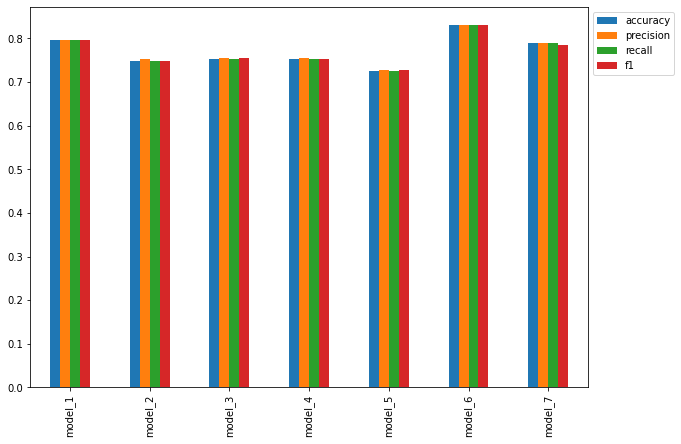

In [152]:
#PLot and compare all of the model reuslts
all_model_results.plot(kind="bar",
                       figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0))

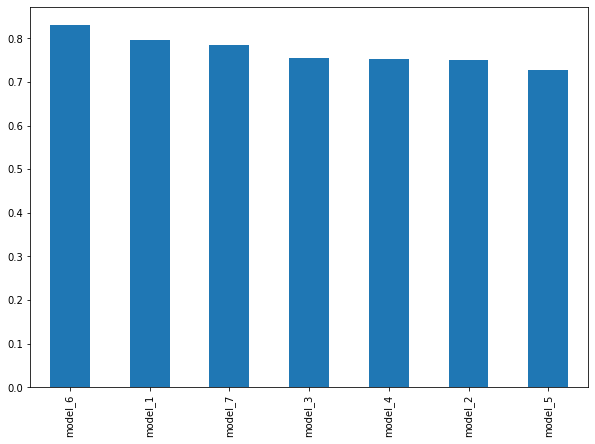

In [153]:
#Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [154]:
# View Tensorboard logs of transfer learning modelling experiemnts
#Upload tensorflow dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple types of model on Hazard Tweets dataset" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=tEvMfvVbyqDeINkTE1xAo5rzrNQdCK&prompt=consent&access_type=offline